# Image Segmentation using an Inception based U-Net model

This notebook is an example notebook of using image data and its corresponding masks to produce masks for the test images whose mask are needed.

Segmentation of an image is to classify each pixel of an image into 2 or more classes. For problems where only one object of interest is needed to be determined in an image containing the object and background, we need to classify every pixel into 2 classes as is the case with the dataset/ model used in this notebook.  

Here is a notebook to do the same using neural network model to find the masks of the images.

In [1]:
import keras, tensorflow, sys
keras.__version__, tensorflow.__version__, sys.version

Using TensorFlow backend.


('2.2.2',
 '1.10.0',
 '3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]')

Used for training on 1st GPU in a multi-GPU environment.

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

## Import packages

Import different packages for handling images and building the keras model.

In [3]:
# Packages for processing/ loading image files
from glob import glob 
import cv2
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split

# Packages for the model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, BatchNormalization
from keras.layers import LeakyReLU, Concatenate, concatenate, UpSampling2D, Add, Input,Dense
from keras.models import Model,load_model
from keras.optimizers import Adam
import tensorflow as tf
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator

# Pacakge for viewing the images
from matplotlib import pyplot as plt
%matplotlib inline

## Function to load and process Image

Load image using opencv function imread(path, 1 for read as colour image).

Cv2 loads the image with B channel first. We converte this to R channel first.

Gaussian Blur is applied to image to have smoother transitions in image. 

Image is scaled to have values between 0 and 1.

For processing masks it is made sure that shapes are as required and the image is thresholded to converte arbitary values to 0 or 255. 

In [4]:
# Preprocess image for of top view training/ detection
def preprocess_img(img_file):
    im = cv2.imread(img_file, 1)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.GaussianBlur(im, (5,5), 0)
    im = im/255
    return im

# Preprocess masks top view
def preprocess_mask(img_file):
    im = cv2.imread(img_file, 0)
    im = im.reshape(im.shape[0], im.shape[1], 1)
    _, im = cv2.threshold(im, 200, 255, cv2.THRESH_BINARY)
    im = cv2.GaussianBlur(im,(5,5), 0)
    im = im.reshape(im.shape[0], im.shape[1], 1)
    im = im/255
    return im

## Inception Block

Instead of a single convolution block an inception block is used to extract the features from the image.

In an inception block input is divided into multiple instances and passed to different combinations of convolution layer and then the output from all the combinations are concatenated and passed further.

An inception block extracts richer feature compared to a convolution layer since in an inception block same input feature is passed through different sized kernel of convolutions, which enables the model to process the features from different point of views. 

Different combinations of layers can be experimented with. Also different inception blocks can be combined in a same model and used as done in the actual inception model.

Link to the paper for Inception model is [here](https://arxiv.org/pdf/1602.07261.pdf).

In [5]:
def incp_v3(x, nb_filters):
    b_1 = Conv2D(nb_filters, (1,1), padding='same', kernel_initializer="glorot_normal")(x)
    b_1 = BatchNormalization(axis=3)(b_1)
    b_1 = LeakyReLU()(b_1)
    b_1 = Conv2D(nb_filters, (3,3), padding='same', kernel_initializer="glorot_normal")(b_1)
    b_1 = BatchNormalization(axis=3)(b_1)
    b_1 = LeakyReLU()(b_1)
    b_1 = Conv2D(nb_filters, (3,3), padding='same', kernel_initializer="glorot_normal")(b_1)
    b_1 = BatchNormalization(axis=3)(b_1)
    b_1 = LeakyReLU()(b_1)
    
    
    b_2 = Conv2D(nb_filters, (1,1), padding='same', kernel_initializer="glorot_normal")(x)
    b_2 = BatchNormalization(axis=3)(b_2)
    b_2 = LeakyReLU()(b_2)
    b_2 = Conv2D(nb_filters, (3,3), padding='same', kernel_initializer="glorot_normal")(b_2)
    b_2 = BatchNormalization(axis=3)(b_2)
    b_2 = LeakyReLU()(b_2)


    b_3 = Conv2D(nb_filters, (1,1), padding='same', kernel_initializer="glorot_normal")(x)
    b_3 = BatchNormalization(axis=3)(b_3)
    b_3 = LeakyReLU()(b_3)

    
    b_4 = MaxPooling2D((2,2), strides=(1,1), padding='same')(x)
    b_4 = Conv2D(nb_filters, (1,1), padding='same', kernel_initializer="glorot_normal")(b_4)
    b_4 = BatchNormalization(axis=3)(b_4)
    b_4 = LeakyReLU()(b_4)
    
    x = concatenate([b_1, b_2, b_3, b_4], axis=3)
    return x

## Dataset

The dataset for this notebook is taken from -> https://www.kaggle.com/kmader/finding-lungs-in-ct-data/home .

The dataset contains 267 images of ct scans of lungs with masks representing the lung portion in each of the image.

The images in the dataset are in tif format.

In [6]:
# Load the training files
X = []
file_train = "./finding-lungs-in-ct-data/2d_images/*.tif"
file_train = glob(file_train)
for i, file in enumerate(file_train):
        im = preprocess_img(file)
        X.append(im)
X = np.array(X)



## change new_crop_blunt_mask file to point to the file where new training masks are present.
file_mask = glob("./finding-lungs-in-ct-data/2d_masks/*.tif")
y = []
for i in file_mask:
        im = preprocess_mask(i)
        y.append(im)  
y = np.array(y)



print(len(X),len(y),len(X)==len(y))

267 267 True


## Sample Image and its corresponding mask

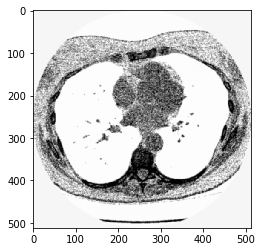

In [7]:
plt.imshow(X[-100][:,:,:])
plt.gray()

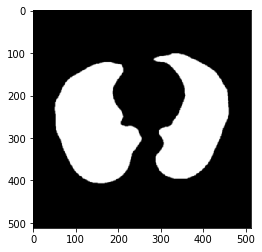

In [8]:
plt.imshow(y[-100][:,:,0])
plt.gray()

In [9]:
X.shape, y.shape

((267, 512, 512, 3), (267, 512, 512, 1))

## Auto Encoder with U-Net Architecture

In an auto encoder model for an image, features are extracted and reduced using a convolution network (or another feature extractor like using inception blocks). The feature size is reduced by max pooling features from each kernel in the convolution. Since, over here, our aim is to get the mask of the input image, we reconstruct the latent features (features found after the last max pooling layer), into an image of same size (channel size may differ). This is done by upsampling (copying the same value in each of the kernel position) and convolution of these features. 

To increase the accuracy of the network an architecture known as U-Net was used. On the decoder side where reconstruction of image is done, along with latent features, corresponding features from encoder is concatenated in each layer. These allows the decoder network to directly look at the features of corresponding layers in the encoder, to enchance feature reproduction. The paper on [U-Net architecture](https://arxiv.org/abs/1505.04597) gives detail information on the same.  

In [10]:
# Initalize the Inception based UNET model

inp = Input(X[0].shape)
x = incp_v3(inp, 8) 

b_0 = x

x = MaxPooling2D((2, 2), strides=2)(x)  
b_1 = (x)

x = incp_v3(x, 16) 

x = MaxPooling2D((2, 2), strides=2)(x) 
b_2 = (x) 

x = incp_v3(x, 32) 

x = MaxPooling2D((2, 2), strides=2)(x) 
b_3 =(x) 

x = incp_v3(x, 64) 

encoded = MaxPooling2D((2, 2))(x) 

x = incp_v3(encoded, 64)

x = UpSampling2D((2, 2))(x) 
x = Concatenate(axis=3)([x, b_3])

x = incp_v3(x, 32)

x = UpSampling2D((2, 2))(x) 
x = Concatenate(axis=3)([x, b_2])

x = incp_v3(x, 16)

x = UpSampling2D((2, 2))(x) 
x = Concatenate(axis=3)([x, b_1])

x = incp_v3(x, 8)

x = UpSampling2D((2, 2))(x) 
x = Concatenate(axis=3)([x, b_0])

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', kernel_initializer='glorot_normal')(x)

model = Model(inp, decoded)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 8)  32          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 8)  32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 512, 512, 8)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [11]:

batch_size = 8

# image_augmenting function
def image_augmentation(imgs, masks): 
    data_gen_args = dict(featurewise_center=False,
                         featurewise_std_normalization=False,
                         zoom_range = [0.9, 1.1],
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         horizontal_flip=True,
                         vertical_flip = True 
                                                ) 
    
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)
    seed = 1
    
    image_datagen.fit(imgs, augment=True, seed=seed)
    mask_datagen.fit(masks, augment=True, seed=seed)
    
    image_generator = image_datagen.flow(
        imgs,
        batch_size=batch_size,
        shuffle=True,
        seed=seed)
    
    mask_generator = mask_datagen.flow(
        masks,
        batch_size=batch_size,
        shuffle=True,
        seed=seed)

    train_generator = zip(image_generator, mask_generator)
    
    return train_generator


In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=3)
x_train.shape, x_test.shape

((240, 512, 512, 3), (27, 512, 512, 3))

In [13]:
train_generator = image_augmentation(x_train, y_train)
test_generator = image_augmentation(x_test, y_test)

In [14]:
from keras.callbacks import TensorBoard,LearningRateScheduler
tb = TensorBoard(log_dir='./logs/lungs_incp_unet', histogram_freq=0, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True,
                 embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

In [15]:
# Model parameters

nb_epoch = 1600

# Train model
callbacks = [tb] 
model.fit_generator(train_generator, steps_per_epoch=30, epochs=nb_epoch, callbacks=callbacks, verbose=0)


## may give location you want to save the model to.
model.save('./lungs_incp_unet')

In [16]:
pred = model.predict(x_test)

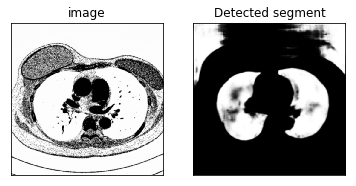

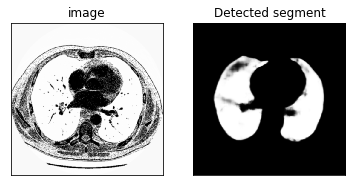

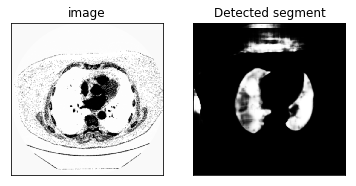

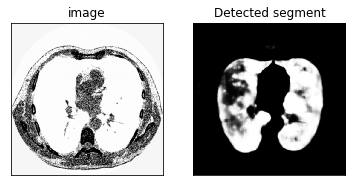

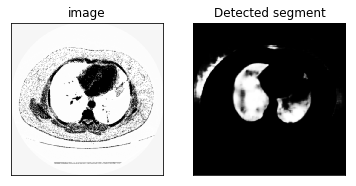

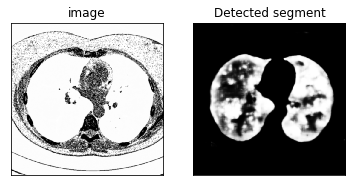

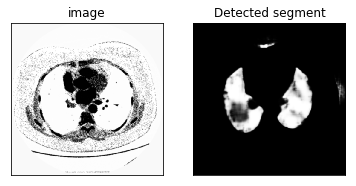

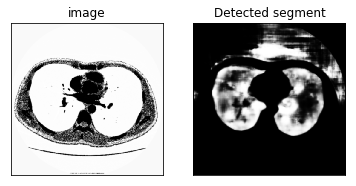

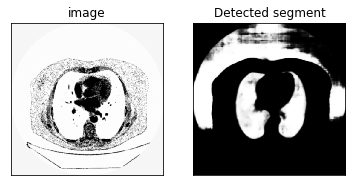

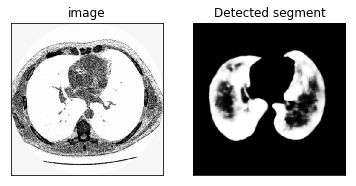

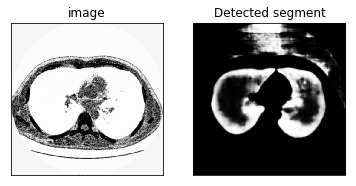

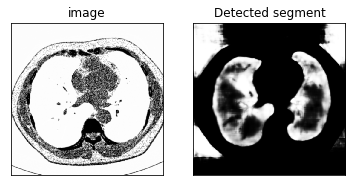

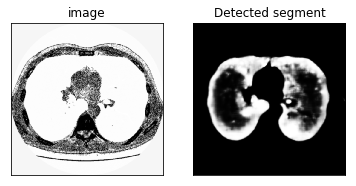

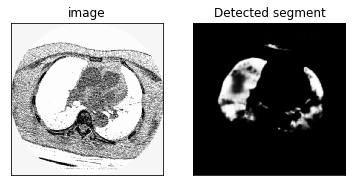

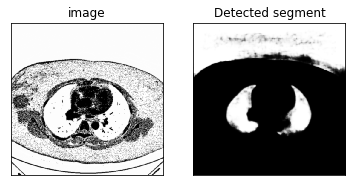

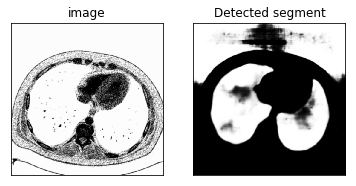

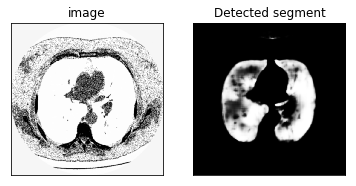

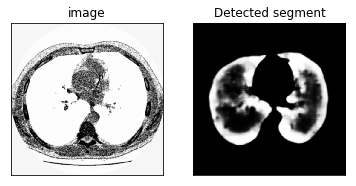

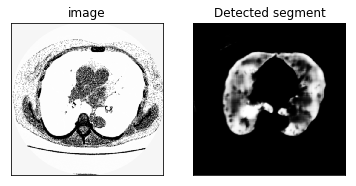

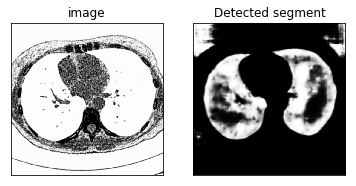

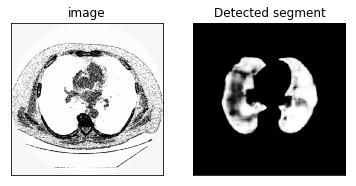

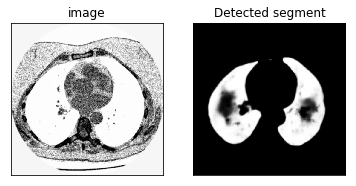

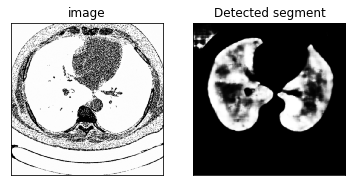

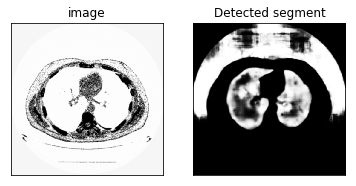

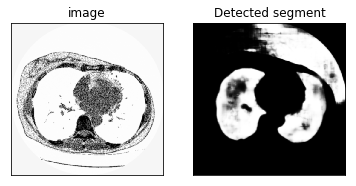

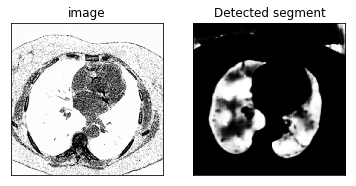

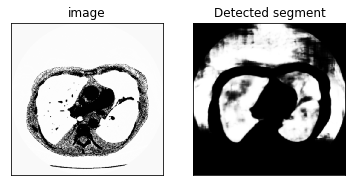

time.struct_time(tm_year=2019, tm_mon=1, tm_mday=18, tm_hour=18, tm_min=34, tm_sec=0, tm_wday=4, tm_yday=18, tm_isdst=0)


In [17]:
plt.gray()
for i, p in enumerate(pred):
    plt.grid(),plt.subplot(122),plt.imshow(p.reshape(p.shape[0],p.shape[1]))
    plt.title('Detected segment'), plt.xticks([]), plt.yticks([])
    plt.grid(),plt.subplot(121),plt.imshow(x_test[i])
    plt.title('image'), plt.xticks([]), plt.yticks([])
    plt.show()
print(time.localtime())

In [18]:
temp = []
for im in y_test:
    im *=255
    _, im = cv2.threshold(im, 200, 255, cv2.THRESH_BINARY)
    temp.append(im)
y_test_t = np.array(temp)

In [19]:
temp = []
for im in pred:
    im *=255
    _, im = cv2.threshold(im, 200, 255, cv2.THRESH_BINARY)
    temp.append(im)
pred_t = np.array(temp)

## IOU

Intersection Over Union is used to evaluate the models performance.

The predicted image is compared with the corresponding mask of the test image.

In [20]:
component1 = np.float32(y_test_t)
component2 = pred_t
overlap = np.logical_and(component1, component2) # Logical AND
union = np.logical_or(component1, component2) # Logical OR

IOU = overlap.sum()/float(union.sum())
IOU

0.43187661214022177